## LSTM Practical: Predicting foil hits in synchrotron beam

In this practical we will attempt to build a time series model that can predict the profile of the beam, specifically the RMS of the x-coordinate profile.

This is a multivariate problem, where we have several parameters as inputs. We have the horizontal and vertical control of the injector that control the incoming beam. We also have the time that the acceleration has been running for and finally we have an estimate of the number of the profile.

The aim of this work is to take the results of the low cost simulation and using the LSTM make them match more closely to the high cost accurate simulation - which is your ground truth Y values in this example. To give a sense of the sppedup, the low cost simulations take about 1 second to run, the ground truth simulations take about 16 hours each.

The data for this practical is plotted below. On the left you can see the vertical and horizontal injector control paramaters. On the right you can see the X$_{RMS}$ from the low cost model and those from the full physics simulation.

<img src="images/lstm-practical-data.png" alt="lstms-2" width="900"/>

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

plt.style.use('ggplot')

# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

Using TensorFlow backend.


## The dataset

The data has been preprocessed a bit - so the values are all normalised to between 0 and 1. Use `pandas` to read the csv `<data_path>/injector-data.csv`

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
data = pd.read_csv(data_path + 'injector-data.csv')
```
    
</p>
</details>


## Our data processing for LSTM function

This is the same fuction that we used in the lecture notebook and will allow us to play with different options for the data. You can copy and paste the function from the [XX_lstm notebook](XX_lstm.ipynb).

### Split into x and y values

In this example the coluumns 1-4 of the data are the input variables and column 5 is the value we wish to predict. In the first instance we will just use the first 100000 data points to train the model. Limiting the data this way results in over-fitting, **but** it will allow us to get the model working and training in a reasonable time.

When we are happy that the model is actually training and learning (albeit over-fitting) we can return and add more data. 

In [4]:
data_limit = 100000
values = data.values
xvalues = values[:data_limit, 1:5]
yvalues = values[:data_limit, 5]

### Refreame the training data

Use the `series_to_supervised` function to convert the `xvalues` to a datframe called `reframedx` which has a past window of 0 steps into the past and a future prediction window of 1 step.


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
reframedx = series_to_supervised(xvalues, 0, 1)
```
    
</p>
</details>


In [5]:
reframedx = series_to_supervised(xvalues, 0, 1)

### Convert to arrays for training

We now reshape the `reframedx` to work with the netword. **Note** we also need to remove the first $n$ values from the y data, where $n$ is the size of the window defined above. When you are tyring different window sizes in future, don't forget to alter this value.

In [6]:
past_steps = 0
x_train = reframedx.values
x_train = x_train.reshape((x_train.shape[0], 4, x_train.shape[1]//4))
ytrain = yvalues[past_steps:]

## Build the network

We will build an $LSTM$ using the template of the network from the [lecture notebook](XX_lstm.ipynb). In the first instance try building a network with one $LSTM$ layer, with 50 units in the layer. The `input_shape` of the network should be `(x_train.shape[1], x_train.shape[2])`.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# Initialising the LSTM
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = False, input_shape=(x_train.shape[1], x_train.shape[2])))

# Adding the output layer
model.add(Dense(units = 1))
```
    
</p>
</details>


## Compile and fit the network

Compile the network to use `mae` as the loss and `adam` as the optimiser.

For training initially run for 30 epochs with a batch size of 128 and a validation split of 0.2. Set `shuffle` to `False` for the fitting.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python

model.compile(loss='mae', optimizer='adam')
history = model.fit(x_train, ytrain, epochs=30, 
                    batch_size=128, validation_split=0.2, 
                    shuffle=False)
```
    
</p>
</details>

Train on 80000 samples, validate on 20000 samples
Epoch 1/30
80000/80000 [==============================] - 6s 78us/step - loss: 0.1154 - val_loss: 0.0396
Epoch 2/30
80000/80000 [==============================] - 6s 71us/step - loss: 0.0536 - val_loss: 0.0449
Epoch 3/30
80000/80000 [==============================] - 6s 70us/step - loss: 0.0525 - val_loss: 0.0439
Epoch 4/30
80000/80000 [==============================] - 5s 68us/step - loss: 0.0518 - val_loss: 0.0434
Epoch 5/30
80000/80000 [==============================] - 5s 68us/step - loss: 0.0513 - val_loss: 0.0427
Epoch 6/30
80000/80000 [==============================] - 6s 69us/step - loss: 0.0509 - val_loss: 0.0426
Epoch 7/30
80000/80000 [==============================] - 6s 70us/step - loss: 0.0507 - val_loss: 0.0424
Epoch 8/30
80000/80000 [==============================] - 5s 68us/step - loss: 0.0504 - val_loss: 0.0427
Epoch 9/30
80000/80000 [==============================] - 5s 69us/step - loss: 0.0501 - val_loss: 0.0427
Epoch

## Take a look at some results

We can look at how the model peroforms on the training set and on an independent test set.

### Training set

First see how we are doing on the training data - if you cannot fit the training data there is no hope on anything else. 
By chaniging the value of `index` below we can choose different samples from the training set.

(0, 660)

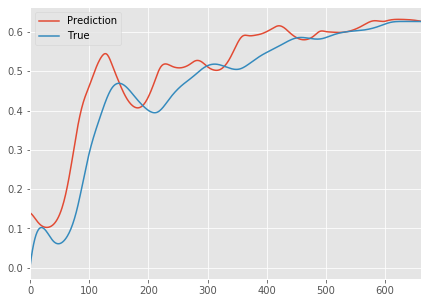

In [9]:
index = 1
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
preds = model.predict(x_train[(index-1)*786+100:index*786])
plt.plot(preds[:, 0], label='Prediction')
plt.plot(ytrain[(index-1)*786:index*786], label='True')

plt.legend()
plt.xlim(0, 660)

### Independent test set

If the model worked okay on the training data a true test is on independent data that was not used for training.

**Note** you will have to alter window size here to match your training data.

In [10]:
window_size = 0
values = data.values
xtestvalues = values[370913:, 1:5]
ytestvalues = values[370913:, 5]
reframedxtest = series_to_supervised(xtestvalues, window_size, 1)
x_test = reframedxtest.values
x_test = x_test.reshape((x_test.shape[0], 4, x_test.shape[1]//4))
ytest = ytestvalues[window_size:]

(100, 680)

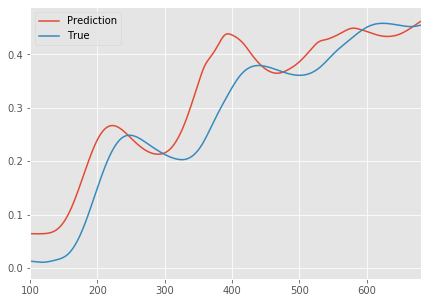

In [11]:
index = 10
preds = model.predict(x_test[(index-1)*786:index*786])
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(preds[100:, 0], label='Prediction')
plt.plot(ytest[(index-1)*786:index*786], label='True')
plt.legend()
plt.xlim(100, 680)

## Hyper-parameter tuning

The network is running, but the results are not very good. Let's try doing some hyper-parameter tuning. 

Here are some things to try:

* Different window sizes
    - [0, 1, 2, 5, 10]
    - Use just 30 epochs for each of these
    
* Increase the number of LSTM layers
    - 1, 2, 3 layers of lstm
    - Use just 30 epochs for each of there
    
When you have found the best options - try to increase the training dataset to 400000 and leave the model to train for 1000 epochs. This will probably take quite a long time, so you might want to leave this running overnight.

**Sample code for hyper-parameter tuning** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python

### Tuning window size
    
import tqdm as tqdm
steps = [0, 1, 2, 5, 10]
histories = []
for step in tqdm.tqdm(steps):
    reframedx = series_to_supervised(xvalues, step, 1)
    past_step = step
    x_train = reframedx.values
    x_train = x_train.reshape((x_train.shape[0], 4, x_train.shape[1]//4))
    ytrain = yvalues[past_step:]
    # Initialising the LSTM
    model = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = False, input_shape=(x_train.shape[1], x_train.shape[2])))

    model.add(Dense(units = 1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(x_train, ytrain, epochs=30, 
                    batch_size=128, validation_split=0.2, 
                    shuffle=False, verbose=0)
    histories.append(history)
    
### Tuning number of lstms

lstms = [1, 2, 3]
step = 5
histories_lstm = []
for lstm in tqdm.tqdm(lstms):
    reframedx = series_to_supervised(xvalues, step, 1)
    past_step = step
    x_train = reframedx.values
    x_train = x_train.reshape((x_train.shape[0], 4, x_train.shape[1]//4))
    ytrain = yvalues[past_step:]
    # Initialising the LSTM
    model = Sequential()
    if lstm == 1:
    # Adding the first LSTM layer and some Dropout regularisation
        model.add(LSTM(units = 50, return_sequences = False, input_shape=(x_train.shape[1], x_train.shape[2])))
    elif lstm == 2:
        model.add(LSTM(units = 50, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(LSTM(units = 50, return_sequences = False))
    elif lstm == 3:
        model.add(LSTM(units = 50, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(LSTM(units = 50, return_sequences = True))
        model.add(LSTM(units = 50, return_sequences = False))
        
        
    model.add(Dense(units = 1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(x_train, ytrain, epochs=30, 
                    batch_size=128, validation_split=0.2, 
                    shuffle=False, verbose=0)
    histories_lstm.append(history)    

```
    
</p>
</details>

100%|██████████| 5/5 [14:25<00:00, 173.13s/it]


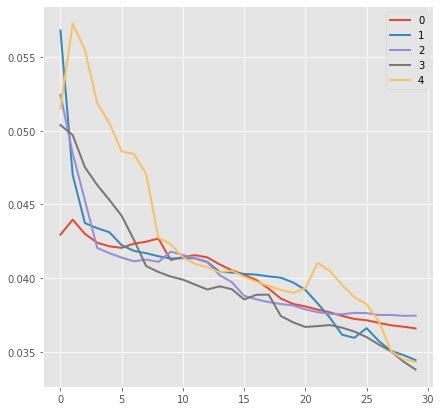

In [13]:
fig, ax, = plt.subplots(1, 1, figsize=(7, 7))
for i in range(5):
    plt.plot(histories[i].history['val_loss'], label='%s'%i, lw=2)
    
plt.legend()


100%|██████████| 3/3 [14:11<00:00, 283.87s/it]


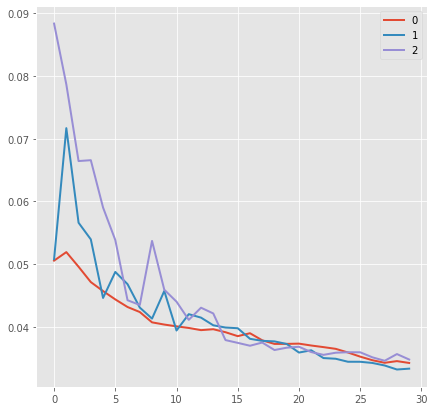

In [15]:
fig, ax, = plt.subplots(1, 1, figsize=(7, 7))
for i in range(3):
    plt.plot(histories_lstm[i].history['val_loss'], label='%s'%i, lw=2)
    
plt.legend()
